# Causal Inference in Peptide Project

Author: **Zhewei Song from  Xtalpi**

This notebook is an exploration of causal inference in Xcausal developed by me using the peptide dataset from macromolecule team.

* Causal Inference is a technique to estimate the effect of one variable onto another, given the presence of other influencing variables(confounding  
  factors) that we try to kepp 'controlled'.

The study looked at the effectiveness of a kind of amino acid of a certain site(the treatment) on the binding affinity of a peptide, after mutating  
from another amino acid.  

The data consist of a number of Rosetta variables(I_sc, ref, dG_cross, delta_unsaHbonds,....), as well as aa treatment indicator, and the real PIC50  
of each sample(the response).  

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

This package rellies heavily on Rubin causal inference material, and so this analysis *Causaal Inference for Statistics, Social, and Biomedical. Sciences:  
An Introduction. Guido W. Imbens and. Donald B. Rubin.*  

The reason why several models exist is that it is impossible to observe the causal effect on a single unit, and so assumptions must be made to estimate the  
missing counterfactuals. We'll explain what that means in this post with one of simple methods called matching.

In [2]:
from Xcausal.utils import peptide_data
from Xcausal import CausalMethod

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pep_df = peptide_data()
pep_df.head()

,Name,PIC50,F0,F1,F2,F3,F4,F5,F6,S6,F7,dG_cross,delta_unsatHbonds,hbonds_int,per_residue_energy_int,nres_int,I_sc,ref,fa_sol,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,fa_elec,fa_dun_rot,fa_atr,dSASA_int
0,0368-0000-0079,8.933469,1,40,0,0,3,35,1,0,3,-51.83970,16.00,5.45,-1.14325,60.30,-51.83910,23.611,1964.09975,401.76265,-47.76215,-29.34990,-44.19635,-318.24530,-872.35185,229.55605,-2783.86000,1871.88820
1,0368-0000-0077,6.768276,1,4,0,0,3,35,1,0,0,-51.13210,13.05,4.95,-1.29840,64.15,-50.99425,24.240,1938.75825,396.84350,-45.19635,-29.00705,-40.61870,-323.45895,-862.49855,227.36715,-2767.02120,1789.68310
2,0368-0000-0073,9.314706,1,40,0,0,3,26,1,0,0,-52.79075,15.75,7.90,-1.14730,60.35,-52.78935,22.960,1983.10510,423.84035,-47.70695,-29.84855,-46.93240,-323.29105,-886.65695,229.20515,-2813.44525,1891.82885
3,0368-0000-0074,9.233290,1,40,0,0,3,26,1,0,0,-51.02890,13.25,7.35,-1.09055,56.65,-51.03025,22.960,1982.76260,470.04545,-48.10735,-29.23945,-46.28110,-318.07630,-879.90255,231.55455,-2815.87745,1838.37390
4,0368-0000-0108,10.004160,1,40,1,0,3,35,1,1,0,-55.51410,13.55,4.60,-1.47795,59.15,-55.51570,23.141,1961.13820,404.30135,-47.30435,-28.92935,-39.96885,-323.84220,-875.95770,228.48595,-2781.79435,1867.77310


At the beginning, I assume that we've located down treatment variables which are F2 site and S6 amino acid type. I convert them into 0, 1 varibales.  
Let's explore S6 causal effect first, **Here is the raw difference in PIC50 between the control group and the treated group:**

In [4]:
pep_df.groupby('S6')['PIC50'].agg(['median','mean'])

,median,mean
S6,,
0,8.540658,8.301132
1,9.955160,9.371808


The treated group has higher binding affinity than the control group - does this mean the treatment had a positive impact? The treatment here means  
this site's amino acid mutates from ASP to DMEASP.

We visualize some important features distributions, these features choice is from insight of human domain knowledges.

S6
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dG_cross, dtype: object

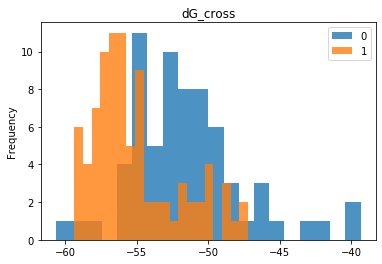

In [5]:
pep_df.groupby('S6')['dG_cross'].plot(kind='hist', bins=20, alpha=0.8, legend=True, title='dG_cross')

S6
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: delta_unsatHbonds, dtype: object

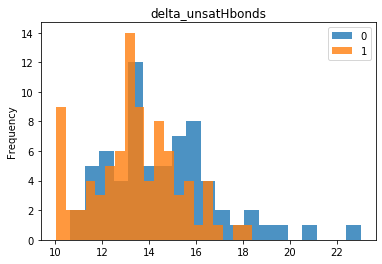

In [6]:
pep_df.groupby('S6')['delta_unsatHbonds'].plot(kind='hist', bins=20, alpha=0.8, legend=True, title='delta_unsatHbonds')

**This dataset is not a balanced trial.** Indeed peptide in the control group are very different from peptide in the treatment group. 

## notation, aims and assumptions  

### Notations.  

* Y represents the response, here is peptides binding affinity('PIC50')
* T represents the treatment: amino acid mutation('S6','F2')
* X represents the confounding variables, here it likely is I_sc, dG_cross, delta_unsatHbonds and so on. X is also called a covariate or the counter factual.  
<br/>
### Aims.  
What we want to know here is the Average Treatment Effect(ATE), Average Treatment Effect on the Treated(ATT), Average Treatment Effect on the controal(ATC):  
<center>ATE = (E[Y<sub>A,1</sub>|T=1] - E[Y'<sub>A,0</sub>|T=0]) + (E[Y'<sub>B,1</sub>|T=1] - E[Y<sub>B,0</sub>|T=0])</center>  
<br/>
<center>ATE = E[Y<sub>A,1</sub>|T=1] -  E[Y<sub>B,0</sub>|T=0]</center>  
<br/>
<center>ATT = E[Y<sub>A,1</sub>|T=1] - E[Y'<sub>A,0</sub>|T=0]</center>  
<br/>
<center>ATC = E[Y'<sub>B,1</sub>|T=1] - E[Y<sub>B,0</sub>|T=0]</center>  

### General problem.  
If we believe that I_sc, dG_cross, delta_unsatHbonds, nres_int all have a likely influence on binding affinity Y, we need a way to distangle the effect of T on  
Y from the perturbative effect of X on Y.  
<br/>

### Assumption.  
The Xcausal package is based on a typical assumption called unconfoundedness or ignorability:  
<center>Y<sub>0</sub>, Y<sub>1</sub>&perp;T|X</center>  
<br/>
Indeed we saw that the treatment assignment is probably not independent of each subject's potential outcomes, e.g. peptide who has higher dG_cross are more  
represented in the treatment group than in the control group.  
<br/>  

However the treatment is assumed to be unconfounded in the sense that the dependence between the treatment assignment and the outcomes is only through  
somethongd we observe, namely the covariates X.  
<br/>
What this means is that if we control for X, i.e. look across peptides with similar levels of X, them the difference between treated and control should be  
attributable to the treatment itself, just as a randomized experiemnt would be.    
<br/>
This is the assumption, and if it doesn't hold our results could be completely wrong.  









## Pre-processing phase  
### Pre-processing phase:  
<font color=Blue>1. assess covariate balance</font>  
2. estimate propensity score  
3. trim sample  
4. stratify sample  
5. caliper   
6. sensitive analysis
....  

### Estimation phase:  
<font color=Blue>1. matching</font>  
2. weighting  
3. blocking  
4. Doubly robust  
5. entropy balancing  
6. approximate residential balance  
.....  
<br/>  
In the pre-processing phase, the data is inspected and manipulated to allow credible analysis to be conducted on it.  
<br/>  
As we discussed in the previous section, one key method for disantangling the treatment effect from the covarieant effects is the  *matching technique.*  
In this technique we compare subjects that have similar covariate values(i.e. I_sc, dG_cross, delta_unsatHbonds, nres_int). However, our ability to  
compare such pairs depends heavily on the degree of overlap of the covariates between the treatment and control group. This is called *covariate balance.*  
<br/>  
Said other wise, to control the effect of dG_cross, one way is to look at peptide in the tested group and in the non-tested group that all have the same level  
of dG_cross, say dG_cross = 55. However, if no sample in the test group has dG_cross equals to that value as many do in the non-test group, this procedure is  
impossible.  
<br/>  
(1) **assess covariate balance** to assess whether how easliy peptide can be matched. If there is too much unbalance, direct matching will raley be possible,  
and we may need to use more complex techniques, if at all possible.


In [7]:
covariates = list(pep_df.columns[-17:]) 
S6_causal = CausalMethod( 
        Y = pep_df['PIC50'], 
        T = pep_df['S6'], 
        X = pep_df[covariates]) 

In [8]:
print(S6_causal.summary_stats)


Summary Statistics

                        Controls (N_c=67)          Treated (N_t=87)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        8.301        1.439        9.372        1.122        1.071

                        Controls (N_c=67)          Treated (N_t=87)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
       dG_cross      -51.531        3.967      -55.161        3.061       -1.025
delta_unsatHbonds       14.584        2.380       13.396        1.903       -0.551
     hbonds_int        5.491        0.869        5.181        1.201       -0.296
per_residue_energy_int       -1.197        0.339       -1.318        0.201       -0.437
       nres_int       59.419        1.954       59.545        2.028        0.0

**Raw-diff** is the raw difference between the means of the control and treatment groups.  
<br/>  
As we saw previously, the treated group PIC50 is increasing 1.071 more than the control group.  
<br/>  
**Nor-diff** in this package is Imbens and Rubin's normalized differences in average covariates, defined as:  
$$\frac{\bar{X}_{k,t} - \bar{X}_{k,c}}{\sqrt{(s^2_{k,t} +s^2_{k,c})/2}}$$  
<br/>  
Here $\bar{X}_{k,t}$ and $s_{k,t}$ are the sample mean and sample standard deviation of the kth covariate of the treatment group, and $\bar{X}_{k,c}$ and $s_{k,c}$  
are the analogous statistics for the control group.  
<br/>  
The aim here is to assess the overlap between the control and treatment groups. It can be seen that dG_cross, I_sc and hbond_sr_bb have a large normalized  
difference, beyond 0.5. This can be interpreted as an imbalance.  
<br/>  
The impact of imbalance is to make the matching technique harder to apply. We'll see later how we can try to correct for it.
 

## Estimation Phase  
In the estimation phase, treatment effects of the dataset can be estimated in several ways.  
<br/>  
**(1) The  matching estimator** - This module is done via nearest-neighborhood matching. If the matching is imperfect, bias correction is recommended.  
If the confounding factors are equal for both element of a pair, the difference between the two will be the real treatment effect. In the Xcausal package,  
samples are weighted by the inverse of the standard deviation of the sample covariate and covariance matrix of feature matrix(Mahalanobis distance) where  
the weight matrix is based on the average of the within-treatment-group sample covariance matrics. 


In [9]:
S6_causal.est_via_matching(weights = 'maha', bias_adj=True, matches=2)
print(S6_causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.185      0.756      1.566      0.117     -0.298      2.667
           ATC      0.694      0.674      1.030      0.303     -0.627      2.016
           ATT      1.562      1.063      1.469      0.142     -0.522      3.646



**This model predicts that the Average Treatment Effect(ATE, the PIC50) is 1.185 extra increasing. This is a little different from previous raw results. But  
It's more precise and giving experts more decision insights.  
<br/>  
Assuming that our model accurately describes the counterfactual X, CausalMethod provides the 95% confidence interval. What this means is that, if we were to repeat this treatment experiment, in 95% of the cases the Average Treatment Effect would be within that interval. That doesn't mean that the true value is within that interval.  
<br/>  
Based on the assumption that the residuals are normally distributed, the 95% confidence interval is calculated as:  
$$\frac{AVG\pm1.96\times STD}{\sqrt{n}}$$  
<br/>  
In practice, as the confidence interval is very large, my interpretion is that the experiment should have had more pepdite if a better estimate of the extra  
increase was desired. Ways to control the standard deviation could also be explored.  
<br/>  
Overall, assuming that we controlled for all the effects and did it well, it seems that the job training had a positive effect on earnings. Indeed, although the standard deviation is very large, the p value of 0.117 rejects the null hypothesis (no effect) with a confidence level of 90% if our significance level is 85%(it should be considered by experience on certain problem) . However, the truth is that we don't know if we modelled the counterfactual well, and this could change everything...  
<br/>  
A more structured approach as we will be developed later which can allow us to increase our confidence that the covariants are well controlled for. We will see many steps!!



## Retry balance assessment after matching

In [10]:
print(S6_causal.att_match_stats)


Summary Statistics

                       Controls (N_c=261)          Treated (N_t=87)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        9.296        0.849        9.372        1.122        0.076

                       Controls (N_c=261)          Treated (N_t=87)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
       dG_cross      -52.860        1.823      -55.161        3.061       -0.914
delta_unsatHbonds       13.057        1.522       13.396        1.903        0.197
     hbonds_int        5.180        0.512        5.181        1.201        0.002
per_residue_energy_int       -1.330        0.100       -1.318        0.201        0.075
       nres_int       59.320        1.020       59.545        2.028        0.1

The important features normalized difference I mentioned before decreases. Imbalance of confounders has been mediated by our matching method.  
Let's quickly choose another treatment variable F2 and quatify the effect again:  

In [13]:
F2_causal = CausalMethod( 
        Y = pep_df['PIC50'], 
        T = pep_df['F2'], 
        X = pep_df[covariates]) 

In [14]:
print(F2_causal.summary_stats)


Summary Statistics

                        Controls (N_c=65)          Treated (N_t=89)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        8.492        1.538        9.209        1.156        0.717

                        Controls (N_c=65)          Treated (N_t=89)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
       dG_cross      -51.402        3.899      -55.174        3.082       -1.073
delta_unsatHbonds       14.860        2.244       13.221        1.894       -0.790
     hbonds_int        5.512        1.063        5.172        1.070       -0.319
per_residue_energy_int       -1.196        0.316       -1.316        0.231       -0.436
       nres_int       59.500        1.979       59.483        2.010       -0.0

In [15]:
F2_causal.est_via_matching(weights = 'inv', bias_adj=True, matches=2)
print(F2_causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.326      1.286      0.253      0.800     -2.195      2.846
           ATC     -0.685      0.972     -0.705      0.481     -2.589      1.220
           ATT      1.064      1.796      0.592      0.554     -2.456      4.584



As we can see, in this result, p-value is far from the reject zone of null hypothesis and confidence interval is large. We should check our data and conclude  
that effect of F2 site's two amino acid mutation is not significant.  
 

## Conclusion  
The effect of dataset is hard to establish firmly. Although it seems the sample from peptide had positive or no-effect effects, it is actually quite likely to be without any effect.  
 <br/>  
We should keep exploring other features that influence peptide binding affinity involving in our experiments.  
 <br/>
More work could be done to better estimate the counterfactual. For instance we could introduce polynomial variables to capture non-linear effects and/or introduce categorical variables to bin numerical variables such as sites amino acid.  
 <br/>
This was just an example of how the Xcausal package could be used. 
